# Random-based Explainability in Turkish Text Classification

## Imports and Parameters

In [1]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:50%; margin-right:auto; margin-left:0;"
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle
from tqdm.notebook import tqdm

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from rand_exp_utils import apply_random
from load_models import prepare_models

<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_rand = config["path_rand"]
thresholds = config["thresholds"]
only_load = config["only_load"]

path_reports = config["path_reports"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

,Parameter,Value
0,path_ttc4900,Data/TTC_4900/
1,path_tr_news,Data/TR_News/
2,path_interpress,Data/Interpress/
3,path_tc32,Data/TC32/
4,path_bert_model_ttc4900,Models/bertturk_text_classification_fine_tuned_ttc4900
5,path_bert_model_tr_news,Models/bertturk_text_classification_fine_tuned_tr_news
6,path_bert_model_interpress,Models/bertturk_text_classification_fine_tuned_interpress
7,path_bert_model_tc32,Models/bertturk_text_classification_fine_tuned_tc32
8,path_tbt_model_ttc4900,Models/turkishbertweet_text_classification_fine_tuned_ttc4900
9,path_tbt_model_tr_news,Models/turkishbertweet_text_classification_fine_tuned_tr_news


## Load Datasets

In [3]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## Random-based Explainability

In [4]:
all_exp_results = pd.DataFrame(columns=["Cl Acc", "ECS FT", "ECS TT", "ORC (+)", "ORC (-)"])

### BERTTurk

#### Inference on Full Text

In [5]:
# Load BERTTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

Error caught was: No module named 'triton'



'bertturk_text_classification_fine_tuned_ttc4900' is loaded.

'bertturk_text_classification_fine_tuned_tr_news' is loaded.

'bertturk_text_classification_fine_tuned_interpress' is loaded.

'bertturk_text_classification_fine_tuned_tc32' is loaded.


In [6]:
path_classification_results = "Data/Classification_Results/BERTTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

In [7]:
num_samples = 50

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

#### TTC4900

In [8]:
ttc4900_bert_results = {}

for threshold in thresholds:

    rand_values_ttc = apply_random(path_rand, ttc4900_test, bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                   f"rand_values_ttc_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(rand_values_ttc, bert_tokenizer_ttc4900, threshold)

    ttc4900_bert_result = compare_probs(ttc4900_test,
                                        bert_full_text_preds_ttc4900,
                                        top_tokens_ttc4900,
                                        None,
                                        bert_model_ttc4900, bert_tokenizer_ttc4900,
                                        id2label=bert_id2label_ttc4900,
                                        device=device)

    ttc4900_bert_results[threshold] = (rand_values_ttc, ttc4900_bert_result)
    
    clear_gpu_memory()
    
    show(ttc4900_bert_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_bert' saved.
'rand_values_ttc_0.5_bert' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_bert' saved.
'rand_values_ttc_0.6_bert' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_bert' saved.
'rand_values_ttc_0.7_bert' file shape: 50



Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.967
Explanations Contribution Score (ECS) of Top Tokens :  0.871
Overall Relative Change (ORC) positive changes      :  0.131 %
Overall Relative Change (ORC) negative changes      : -11.544 %


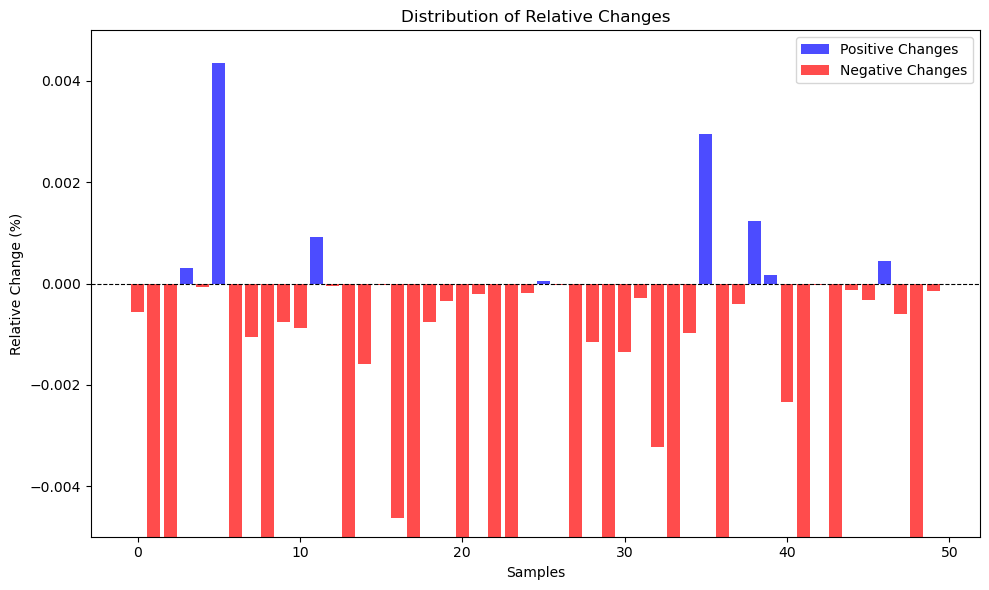


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.967
Explanations Contribution Score (ECS) of Top Tokens :  0.879
Overall Relative Change (ORC) positive changes      :  3.861 %
Overall Relative Change (ORC) negative changes      : -13.351 %


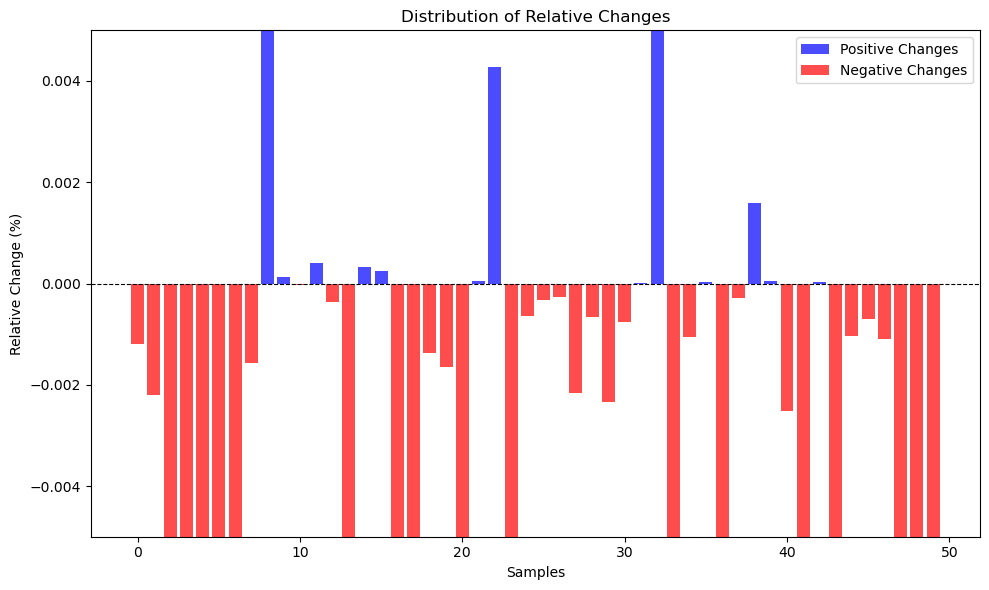


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.967
Explanations Contribution Score (ECS) of Top Tokens :  0.873
Overall Relative Change (ORC) positive changes      :  2.326 %
Overall Relative Change (ORC) negative changes      : -11.69 %


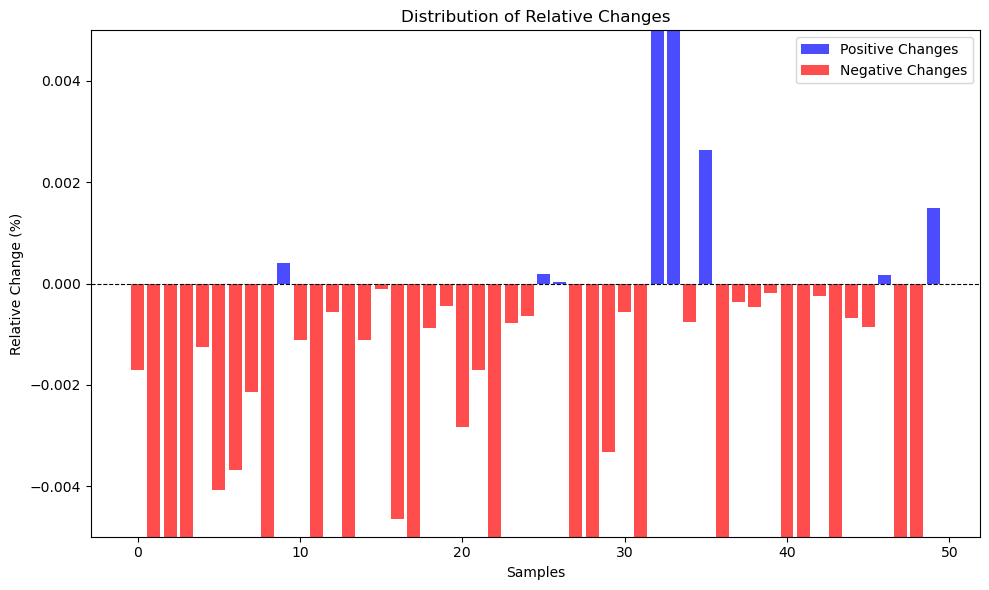

In [9]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [10]:
tr_news_bert_results = {}

for threshold in thresholds:

    rand_values_tr_news = apply_random(path_rand, tr_news_test, bert_model_tr_news, bert_tokenizer_tr_news, 
                                       f"rand_values_tr_news_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(rand_values_tr_news, bert_tokenizer_tr_news, threshold)

    tr_news_bert_result = compare_probs(tr_news_test,
                                        bert_full_text_preds_tr_news,
                                        top_tokens_tr_news,
                                        None,
                                        bert_model_tr_news, bert_tokenizer_tr_news,
                                        id2label=bert_id2label_tr_news,
                                        device=device)

    tr_news_bert_results[threshold] = (rand_values_tr_news, tr_news_bert_result)
    
    clear_gpu_memory()
    
    show(tr_news_bert_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/50 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


File 'rand_values_tr_news_0.5_bert' saved.
'rand_values_tr_news_0.5_bert' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_bert' saved.
'rand_values_tr_news_0.6_bert' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_bert' saved.
'rand_values_tr_news_0.7_bert' file shape: 50



Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.848
Explanations Contribution Score (ECS) of Top Tokens :  0.614
Overall Relative Change (ORC) positive changes      :  6.077 %
Overall Relative Change (ORC) negative changes      : -27.471 %


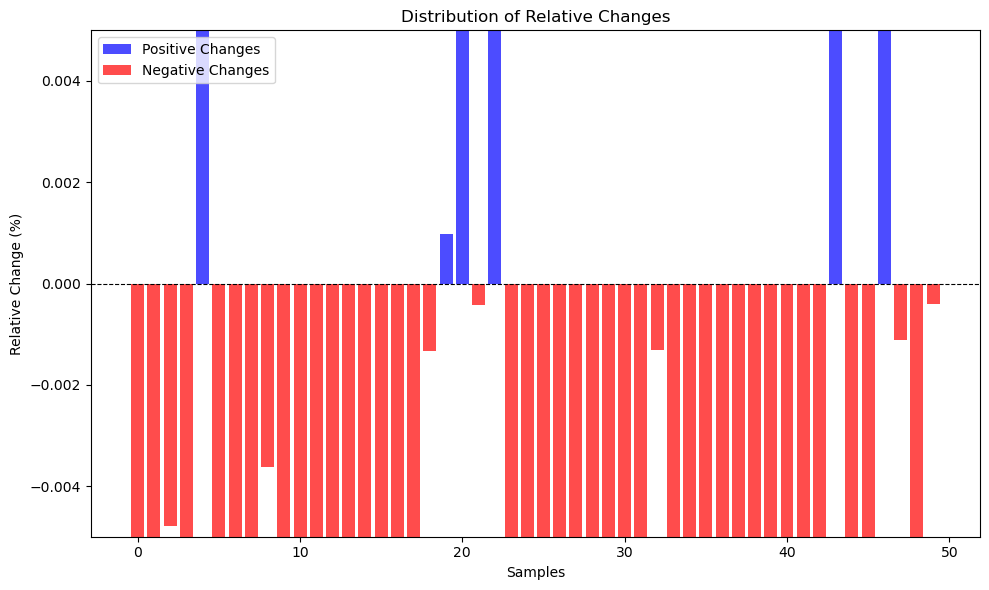


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.848
Explanations Contribution Score (ECS) of Top Tokens :  0.635
Overall Relative Change (ORC) positive changes      :  10.279 %
Overall Relative Change (ORC) negative changes      : -26.486 %


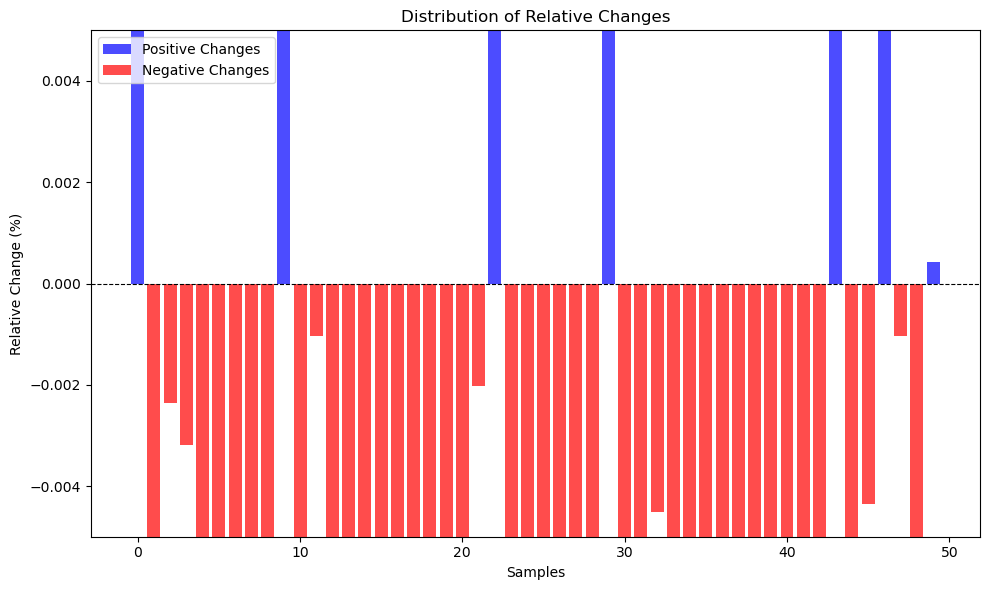


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.848
Explanations Contribution Score (ECS) of Top Tokens :  0.618
Overall Relative Change (ORC) positive changes      :  8.55 %
Overall Relative Change (ORC) negative changes      : -25.02 %


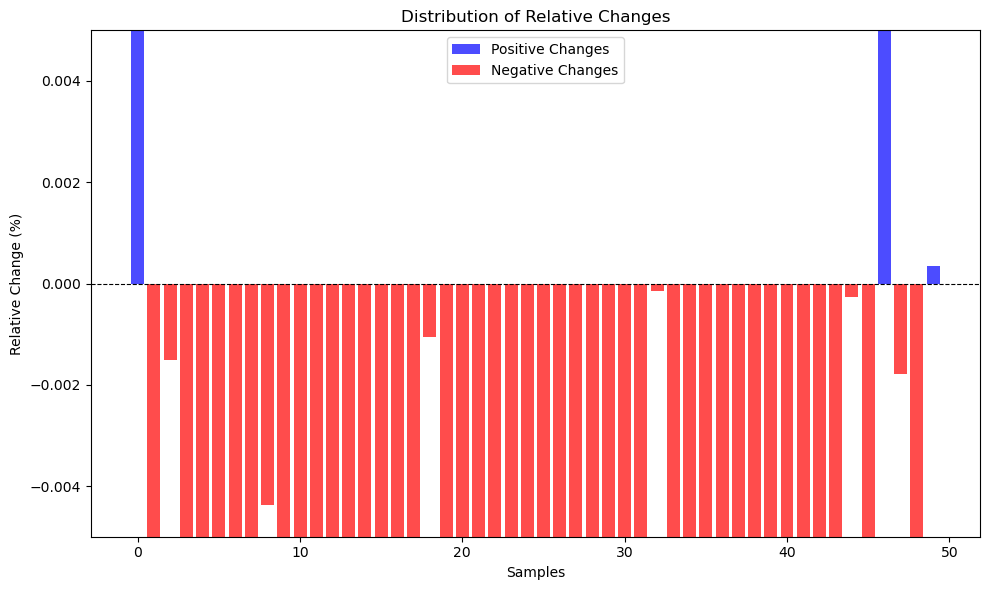

In [11]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [12]:
interpress_bert_results = {}

for threshold in thresholds:

    rand_values_interpress = apply_random(path_rand, interpress_test, bert_model_interpress, bert_tokenizer_interpress, 
                                          f"rand_values_interpress_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(rand_values_interpress, bert_tokenizer_interpress, threshold)

    interpress_bert_result = compare_probs(interpress_test,
                                           bert_full_text_preds_interpress,
                                           top_tokens_interpress,
                                           None,
                                           bert_model_interpress, bert_tokenizer_interpress,
                                           id2label=bert_id2label_interpress,
                                           device=device)

    interpress_bert_results[threshold] = (rand_values_interpress, interpress_bert_result)
    
    clear_gpu_memory()
    
    show(interpress_bert_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_bert' saved.
'rand_values_interpress_0.5_bert' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_bert' saved.
'rand_values_interpress_0.6_bert' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_bert' saved.
'rand_values_interpress_0.7_bert' file shape: 50



Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.839
Overall Relative Change (ORC) positive changes      :  5.497 %
Overall Relative Change (ORC) negative changes      : -12.843 %


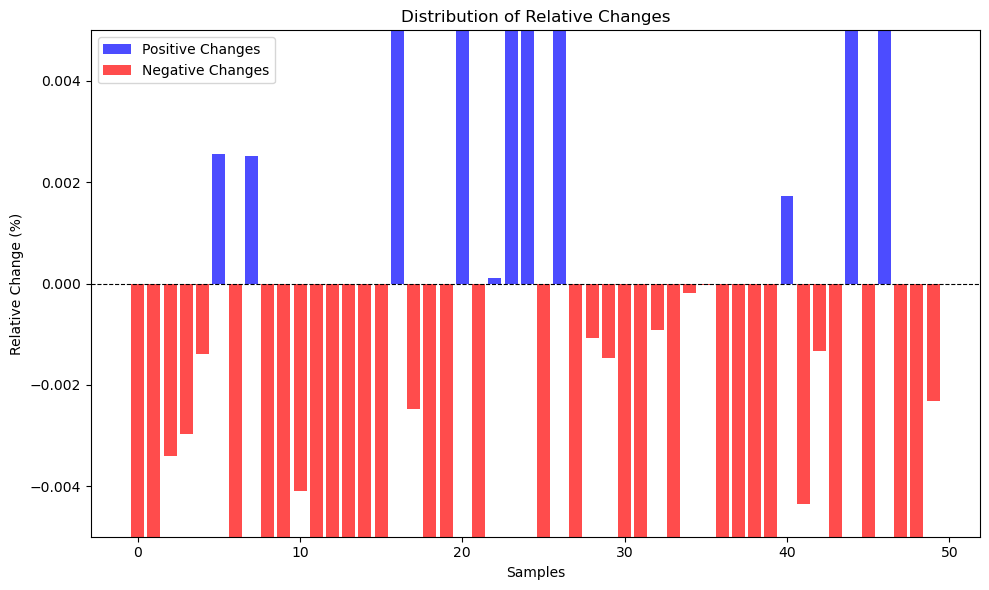


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.746
Overall Relative Change (ORC) positive changes      :  3.019 %
Overall Relative Change (ORC) negative changes      : -23.998 %


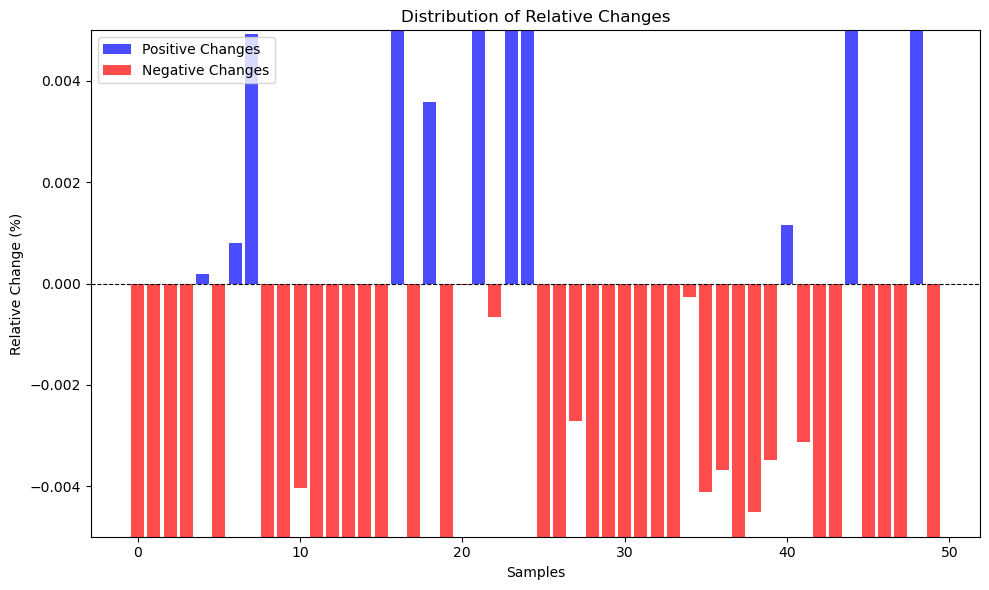


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.749
Overall Relative Change (ORC) positive changes      :  6.586 %
Overall Relative Change (ORC) negative changes      : -24.601 %


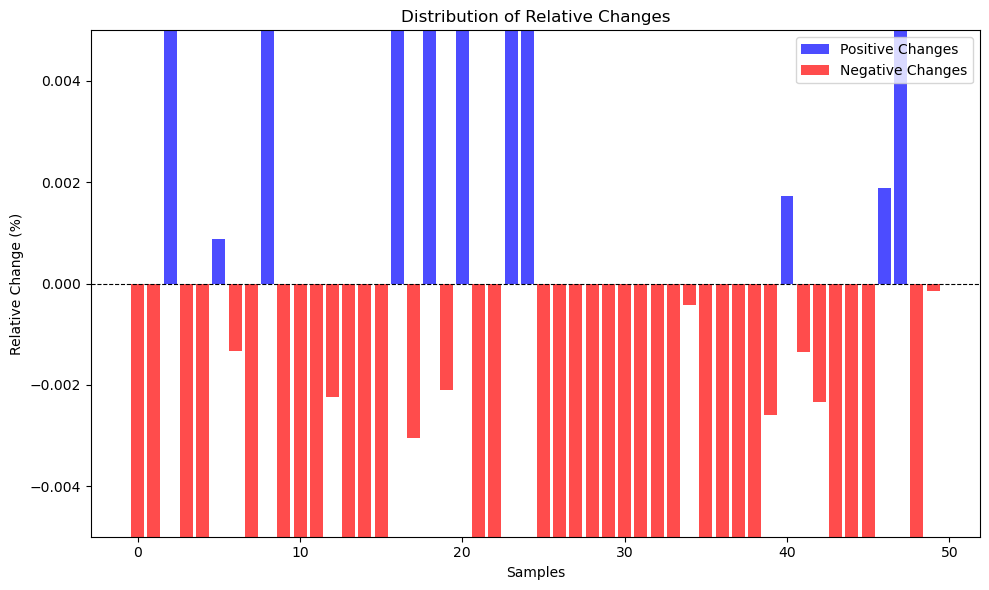

In [13]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC 32

In [14]:
tc32_bert_results = {}

for threshold in thresholds:

    rand_values_tc32 = apply_random(path_rand, tc32_test, bert_model_tc32, bert_tokenizer_tc32, 
                                    f"rand_values_tc32_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(rand_values_tc32, bert_tokenizer_tc32, threshold)

    tc32_bert_result = compare_probs(tc32_test,
                                     bert_full_text_preds_tc32,
                                     top_tokens_tc32,
                                     None,
                                     bert_model_tc32, bert_tokenizer_tc32,
                                     id2label=bert_id2label_tc32,
                                     device=device)

    tc32_bert_results[threshold] = (rand_values_tc32, tc32_bert_result)
    
    clear_gpu_memory()
    
    show(tc32_bert_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_bert' saved.
'rand_values_tc32_0.5_bert' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_bert' saved.
'rand_values_tc32_0.6_bert' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_bert' saved.
'rand_values_tc32_0.7_bert' file shape: 50



Classification accuracy                             :  0.94
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.536
Overall Relative Change (ORC) positive changes      :  nan %
Overall Relative Change (ORC) negative changes      : -45.653 %


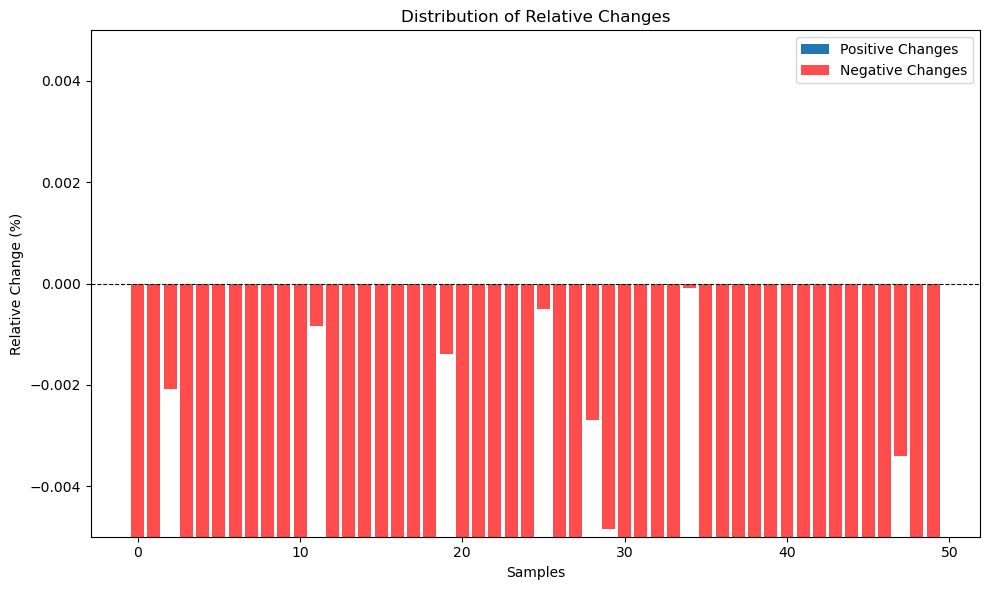


Classification accuracy                             :  0.94
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.497
Overall Relative Change (ORC) positive changes      :  19.849 %
Overall Relative Change (ORC) negative changes      : -51.016 %


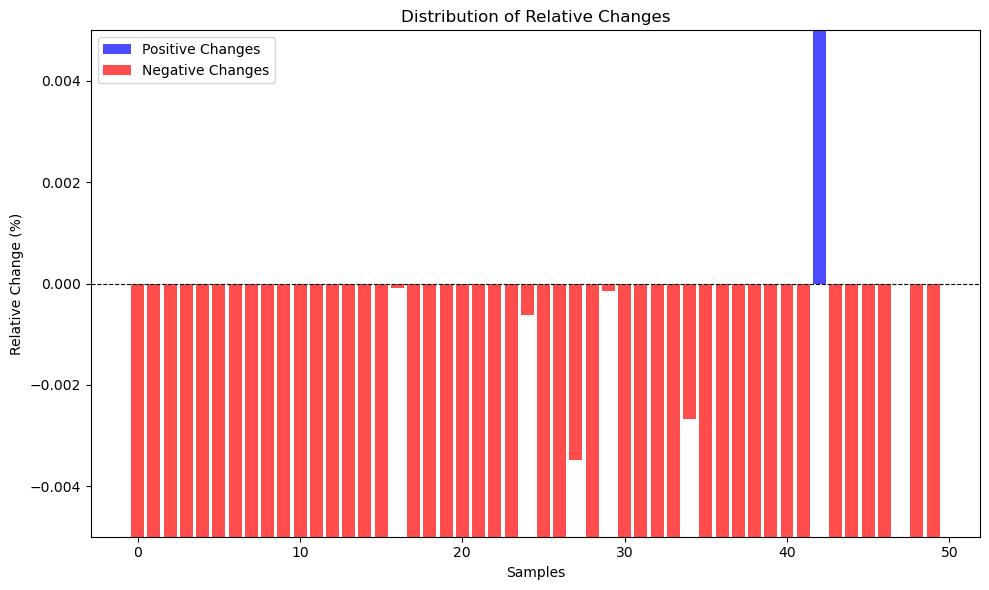


Classification accuracy                             :  0.94
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.482
Overall Relative Change (ORC) positive changes      :  21.274 %
Overall Relative Change (ORC) negative changes      : -52.605 %


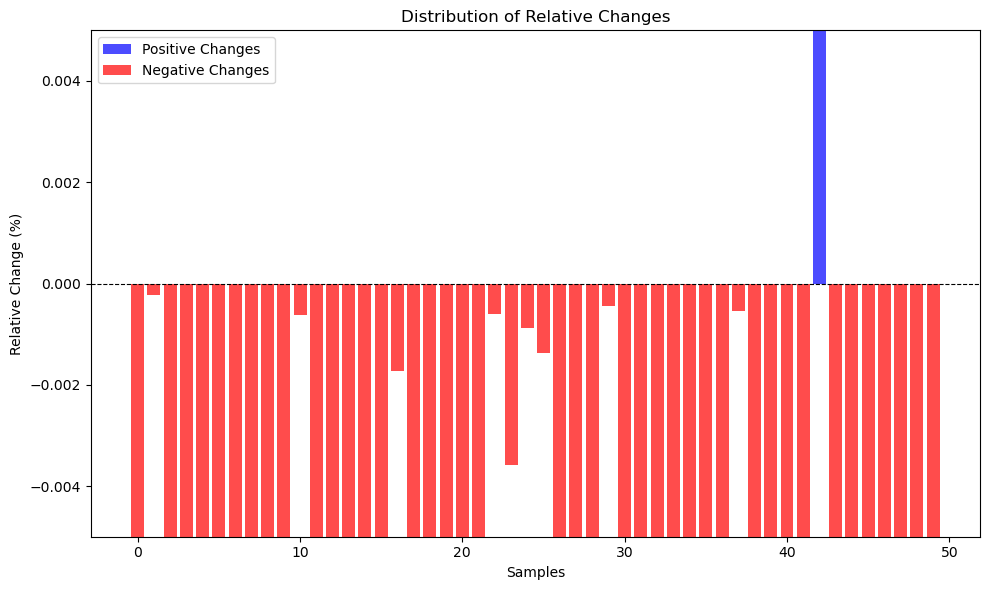

In [15]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### Inference on Full Text

In [16]:
# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)


'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


In [17]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

In [18]:
tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

#### TTC4900

In [19]:
ttc4900_tbt_results = {}

for threshold in thresholds:

    rand_values_ttc = apply_random(path_rand, ttc4900_test, tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                   f"rand_values_ttc_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(rand_values_ttc, tbt_tokenizer_ttc4900, threshold)

    ttc4900_tbt_result = compare_probs(ttc4900_test,
                                       tbt_full_text_preds_ttc4900,
                                       top_tokens_ttc4900,
                                       None,
                                       tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                       id2label=tbt_id2label_ttc4900,
                                       device=device)

    ttc4900_tbt_results[threshold] = (rand_values_ttc, ttc4900_tbt_result)
    
    clear_gpu_memory()
    
    show(ttc4900_tbt_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_ttc_0.5_tbt' saved.
'rand_values_ttc_0.5_tbt' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_ttc_0.6_tbt' saved.
'rand_values_ttc_0.6_tbt' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_ttc_0.7_tbt' saved.
'rand_values_ttc_0.7_tbt' file shape: 50



Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.976
Explanations Contribution Score (ECS) of Top Tokens :  0.948
Overall Relative Change (ORC) positive changes      :  1.485 %
Overall Relative Change (ORC) negative changes      : -5.93 %


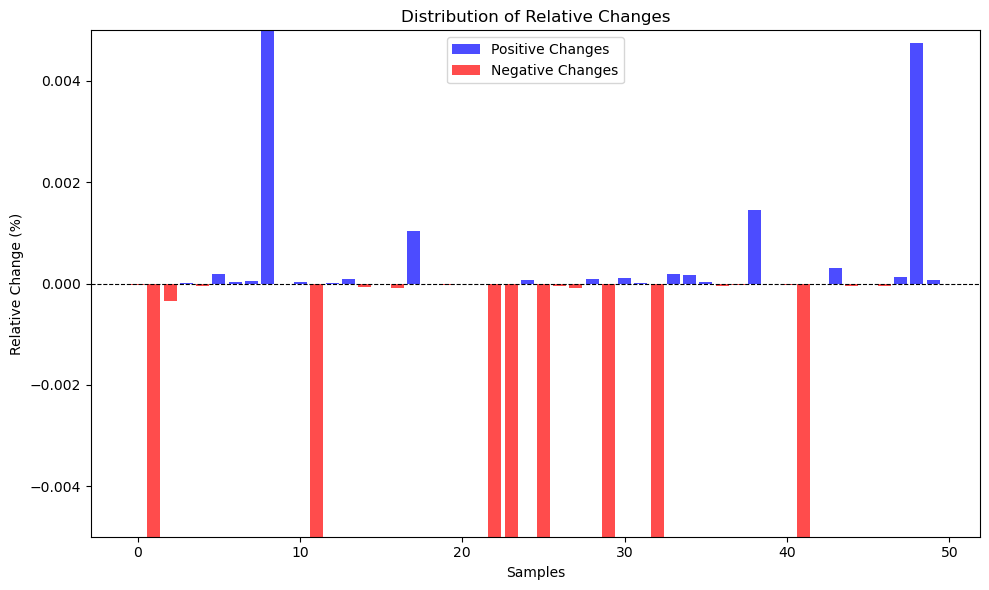


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.976
Explanations Contribution Score (ECS) of Top Tokens :  0.889
Overall Relative Change (ORC) positive changes      :  0.019 %
Overall Relative Change (ORC) negative changes      : -14.485 %


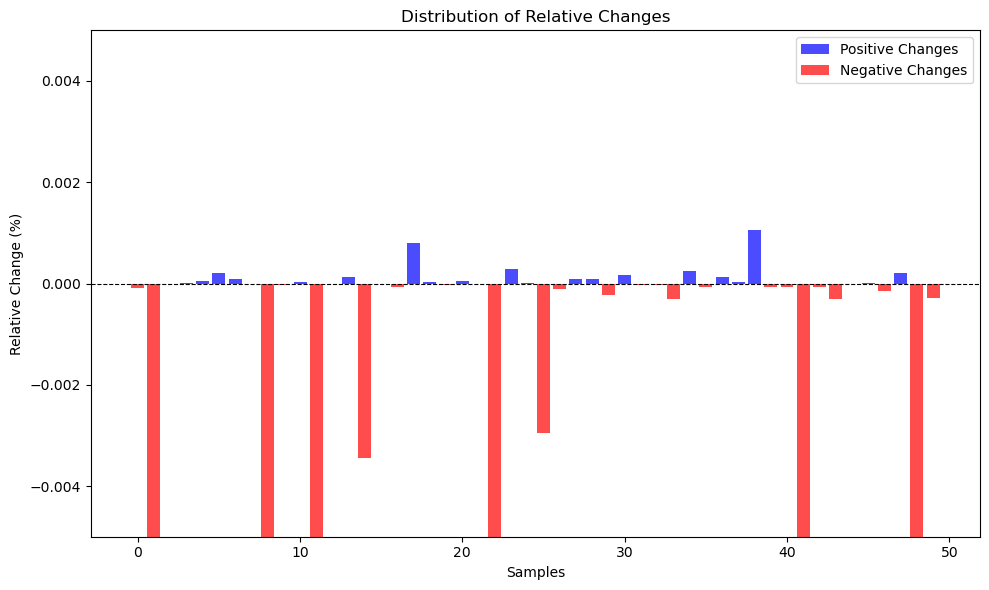


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.976
Explanations Contribution Score (ECS) of Top Tokens :  0.93
Overall Relative Change (ORC) positive changes      :  1.952 %
Overall Relative Change (ORC) negative changes      : -7.707 %


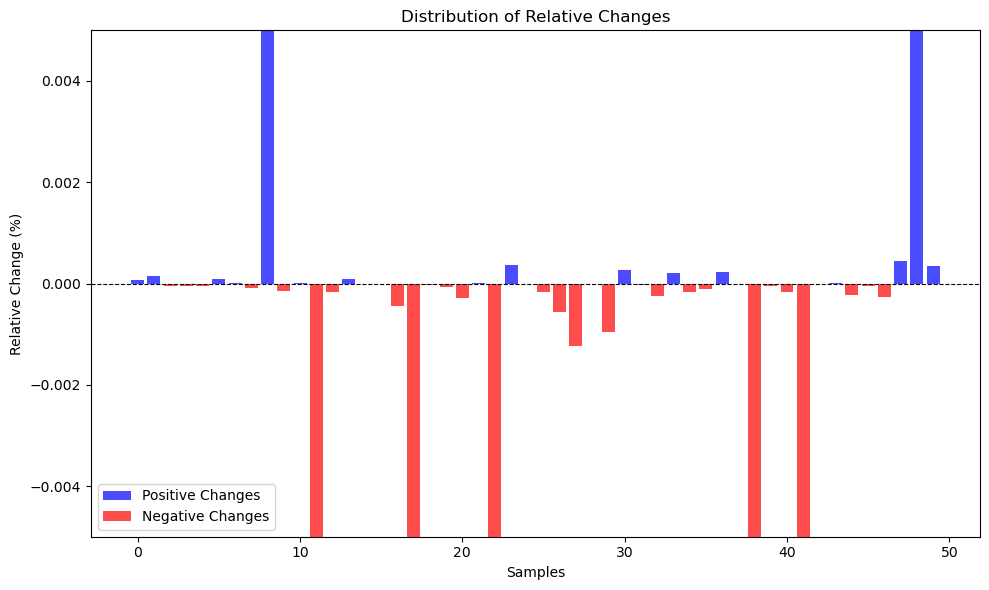

In [20]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [21]:
tr_news_tbt_results = {}

for threshold in thresholds:

    rand_values_tr_news = apply_random(path_rand, tr_news_test, tbt_model_tr_news, tbt_tokenizer_tr_news, 
                                       f"rand_values_tr_news_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(rand_values_tr_news, tbt_tokenizer_tr_news, threshold)

    tr_news_tbt_result = compare_probs(tr_news_test,
                                       tbt_full_text_preds_tr_news,
                                       top_tokens_tr_news,
                                       None,
                                       tbt_model_tr_news, tbt_tokenizer_tr_news,
                                       id2label=tbt_id2label_tr_news,
                                       device=device)

    tr_news_tbt_results[threshold] = (rand_values_tr_news, tr_news_tbt_result)
    
    clear_gpu_memory()
    
    show(tr_news_tbt_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.5_tbt' saved.
'rand_values_tr_news_0.5_tbt' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.6_tbt' saved.
'rand_values_tr_news_0.6_tbt' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tr_news_0.7_tbt' saved.
'rand_values_tr_news_0.7_tbt' file shape: 50



Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.808
Explanations Contribution Score (ECS) of Top Tokens :  0.675
Overall Relative Change (ORC) positive changes      :  5.27 %
Overall Relative Change (ORC) negative changes      : -21.306 %


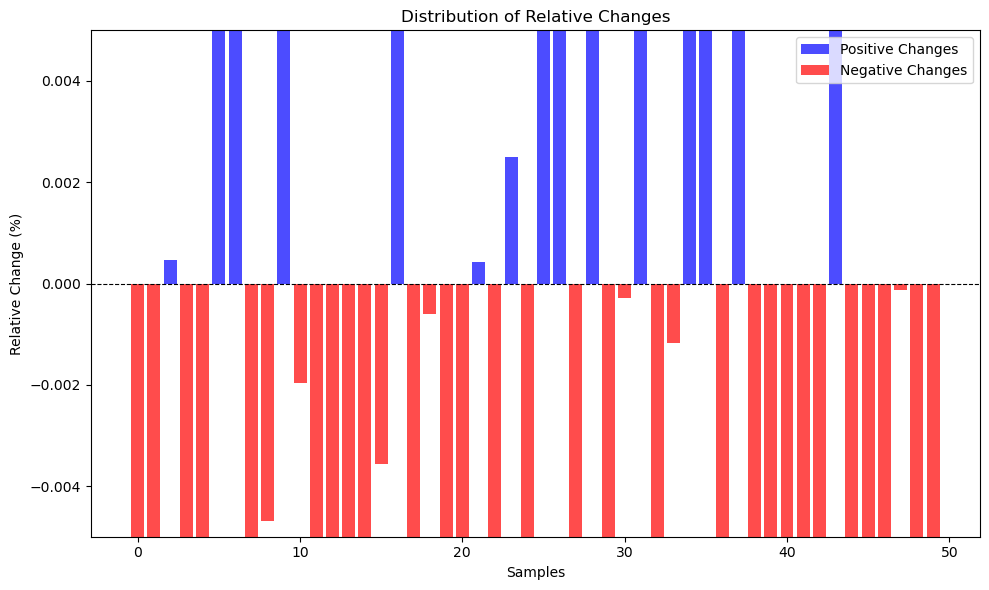


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.808
Explanations Contribution Score (ECS) of Top Tokens :  0.662
Overall Relative Change (ORC) positive changes      :  5.988 %
Overall Relative Change (ORC) negative changes      : -24.281 %


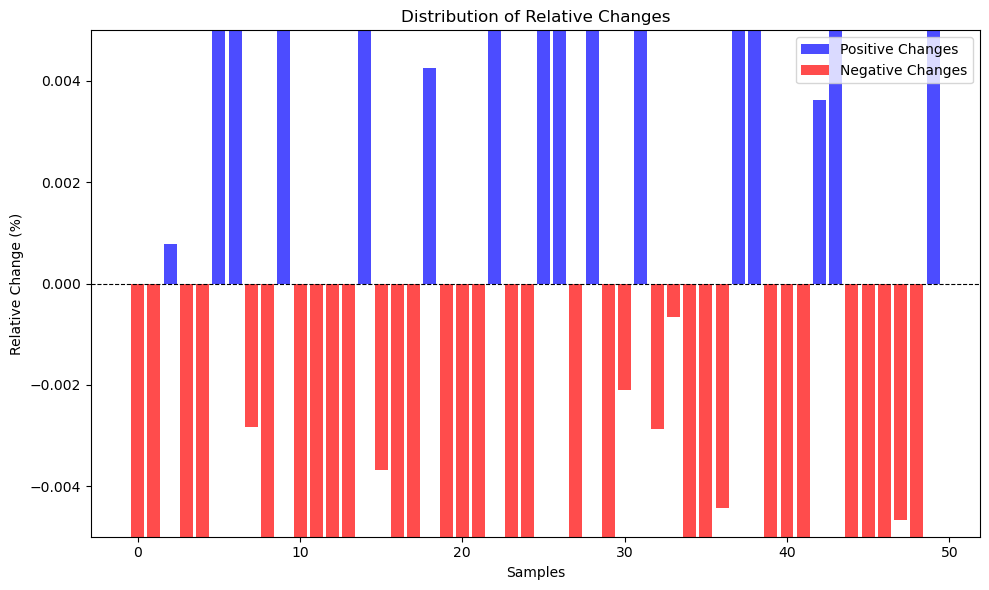


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.808
Explanations Contribution Score (ECS) of Top Tokens :  0.576
Overall Relative Change (ORC) positive changes      :  2.809 %
Overall Relative Change (ORC) negative changes      : -32.399 %


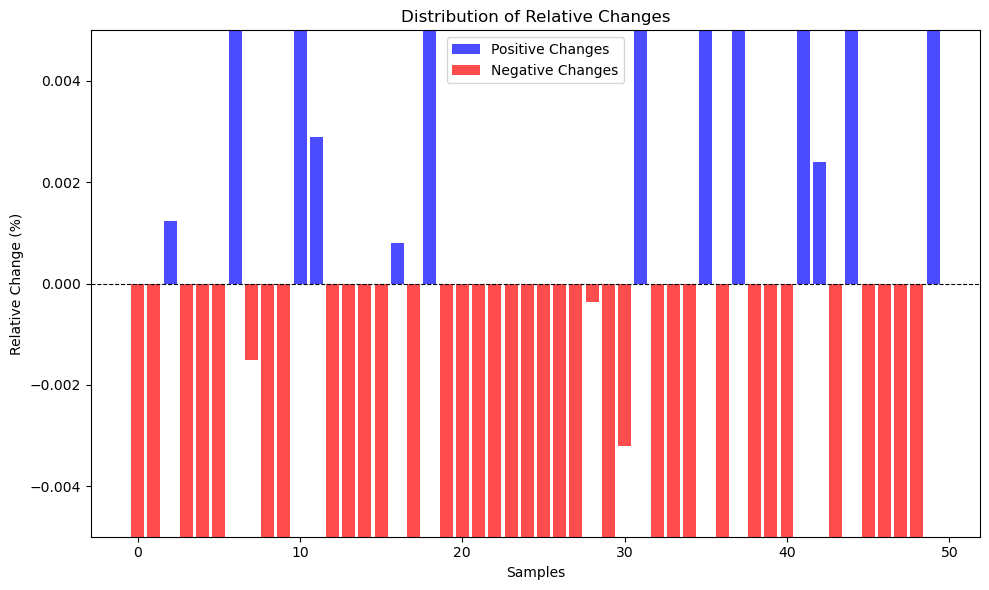

In [22]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [23]:
interpress_tbt_results = {}

for threshold in thresholds:

    rand_values_interpress = apply_random(path_rand, interpress_test, tbt_model_interpress, tbt_tokenizer_interpress, 
                                          f"rand_values_interpress_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(rand_values_interpress, tbt_tokenizer_interpress, threshold)

    interpress_tbt_result = compare_probs(interpress_test,
                                          tbt_full_text_preds_interpress,
                                          top_tokens_interpress,
                                          None,
                                          tbt_model_interpress, tbt_tokenizer_interpress,
                                          id2label=tbt_id2label_interpress,
                                          device=device)

    interpress_tbt_results[threshold] = (rand_values_interpress, interpress_tbt_result)
    
    clear_gpu_memory()
    
    show(interpress_tbt_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_interpress_0.5_tbt' saved.
'rand_values_interpress_0.5_tbt' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_interpress_0.6_tbt' saved.
'rand_values_interpress_0.6_tbt' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_interpress_0.7_tbt' saved.
'rand_values_interpress_0.7_tbt' file shape: 50



Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.844
Explanations Contribution Score (ECS) of Top Tokens :  0.6
Overall Relative Change (ORC) positive changes      :  10.308 %
Overall Relative Change (ORC) negative changes      : -39.238 %


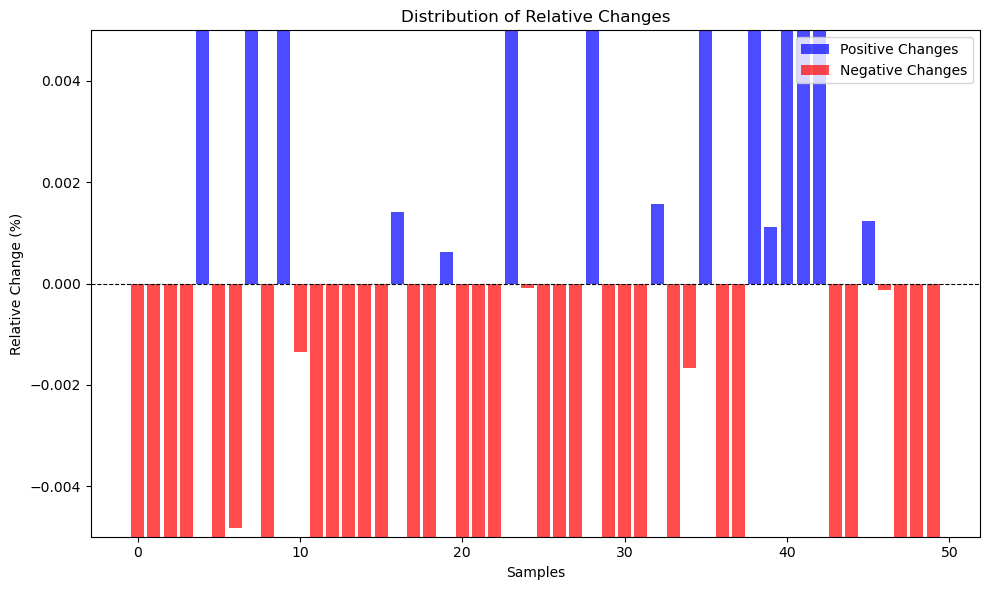


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.844
Explanations Contribution Score (ECS) of Top Tokens :  0.593
Overall Relative Change (ORC) positive changes      :  10.874 %
Overall Relative Change (ORC) negative changes      : -42.018 %


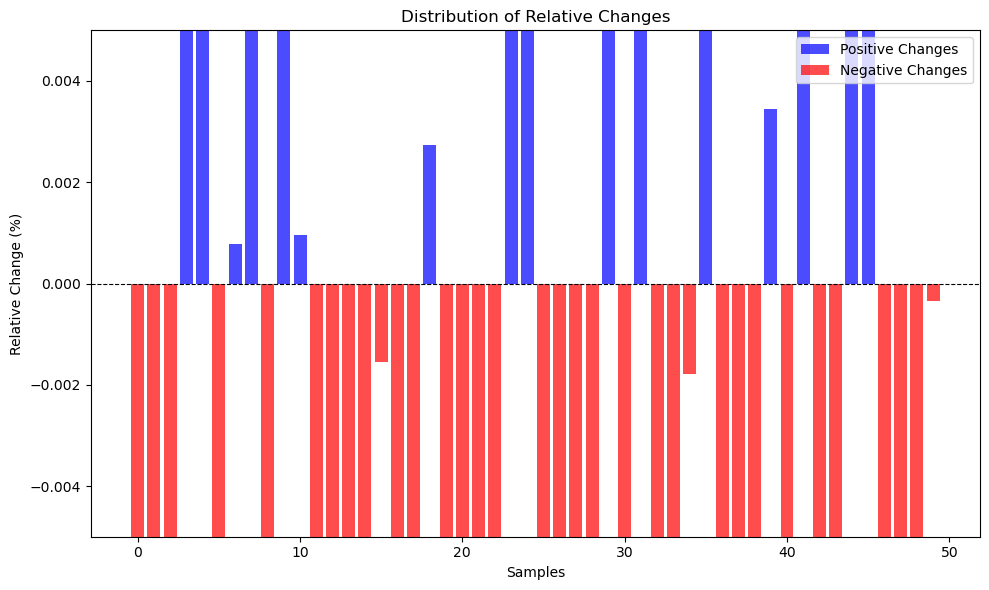


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.844
Explanations Contribution Score (ECS) of Top Tokens :  0.535
Overall Relative Change (ORC) positive changes      :  9.514 %
Overall Relative Change (ORC) negative changes      : -48.241 %


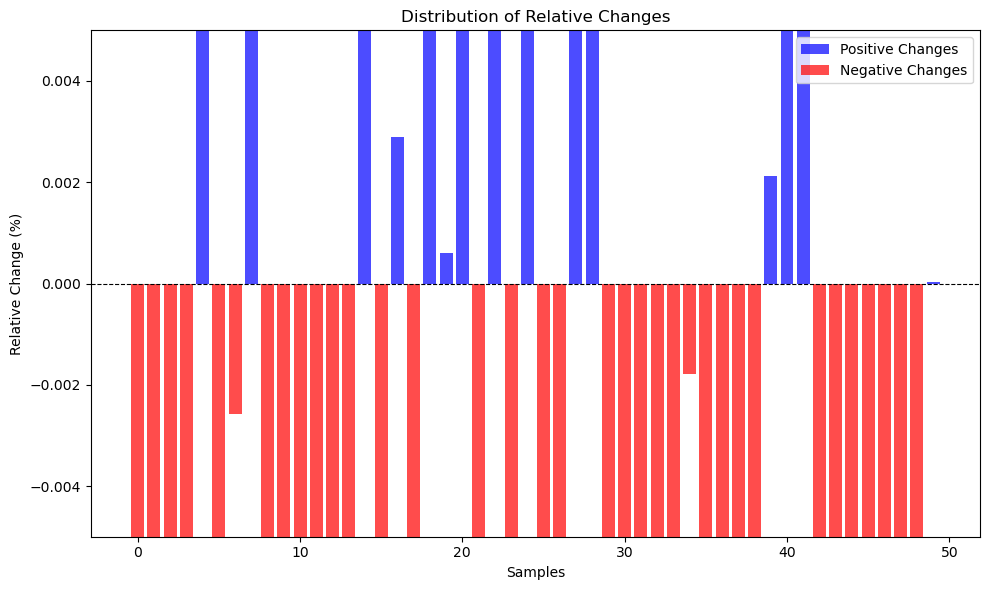

In [24]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [25]:
tc32_tbt_results = {}

for threshold in thresholds:

    rand_values_tc32 = apply_random(path_rand, tc32_test, tbt_model_tc32, tbt_tokenizer_tc32, 
                                    f"rand_values_tc32_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(rand_values_tc32, tbt_tokenizer_tc32, threshold)

    tc32_tbt_result = compare_probs(tc32_test,
                                    tbt_full_text_preds_tc32,
                                    top_tokens_tc32,
                                    None,
                                    tbt_model_tc32, tbt_tokenizer_tc32,
                                    id2label=tbt_id2label_tc32,
                                    device=device)

    tc32_tbt_results[threshold] = (rand_values_tc32, tc32_tbt_result)
    
    clear_gpu_memory()
    
    show(tc32_tbt_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tc32_0.5_tbt' saved.
'rand_values_tc32_0.5_tbt' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tc32_0.6_tbt' saved.
'rand_values_tc32_0.6_tbt' file shape: 50


  0%|          | 0/50 [00:00<?, ?it/s]

File 'rand_values_tc32_0.7_tbt' saved.
'rand_values_tc32_0.7_tbt' file shape: 50



Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.942
Explanations Contribution Score (ECS) of Top Tokens :  0.417
Overall Relative Change (ORC) positive changes      :  0.472 %
Overall Relative Change (ORC) negative changes      : -53.567 %


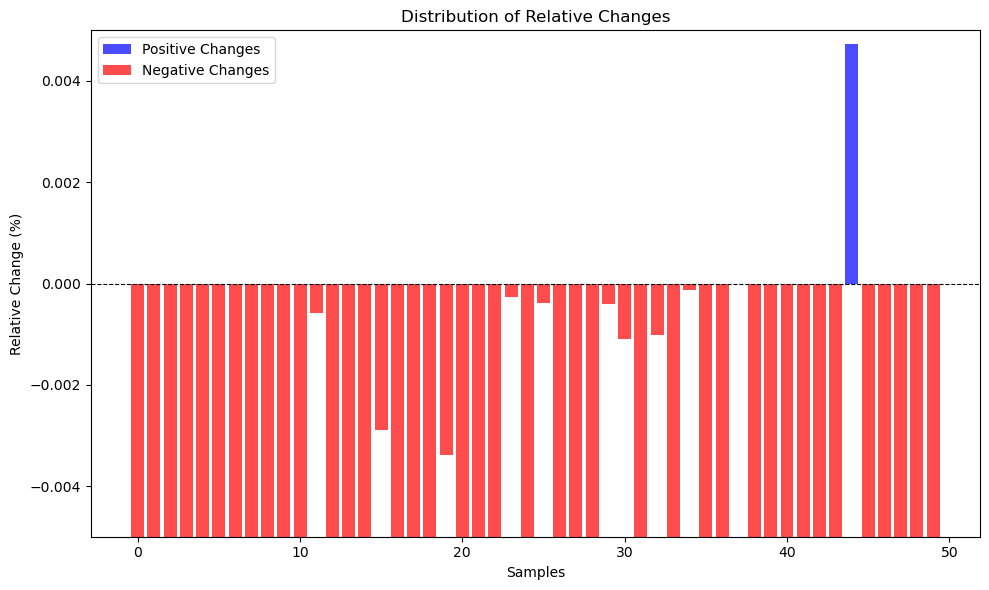


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.942
Explanations Contribution Score (ECS) of Top Tokens :  0.411
Overall Relative Change (ORC) positive changes      :  0.004 %
Overall Relative Change (ORC) negative changes      : -54.174 %


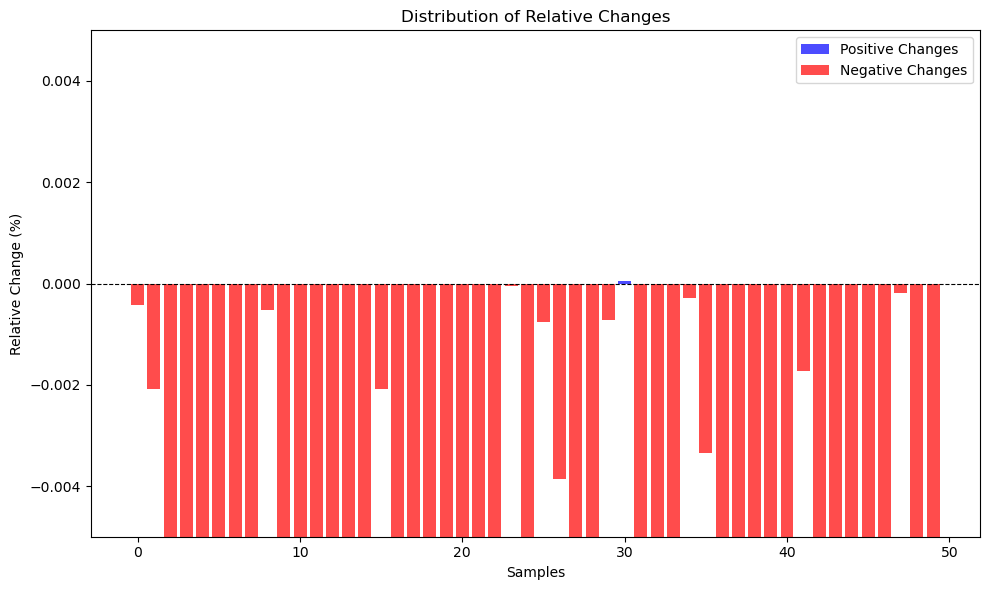


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.942
Explanations Contribution Score (ECS) of Top Tokens :  0.372
Overall Relative Change (ORC) positive changes      :  4.503 %
Overall Relative Change (ORC) negative changes      : -59.588 %


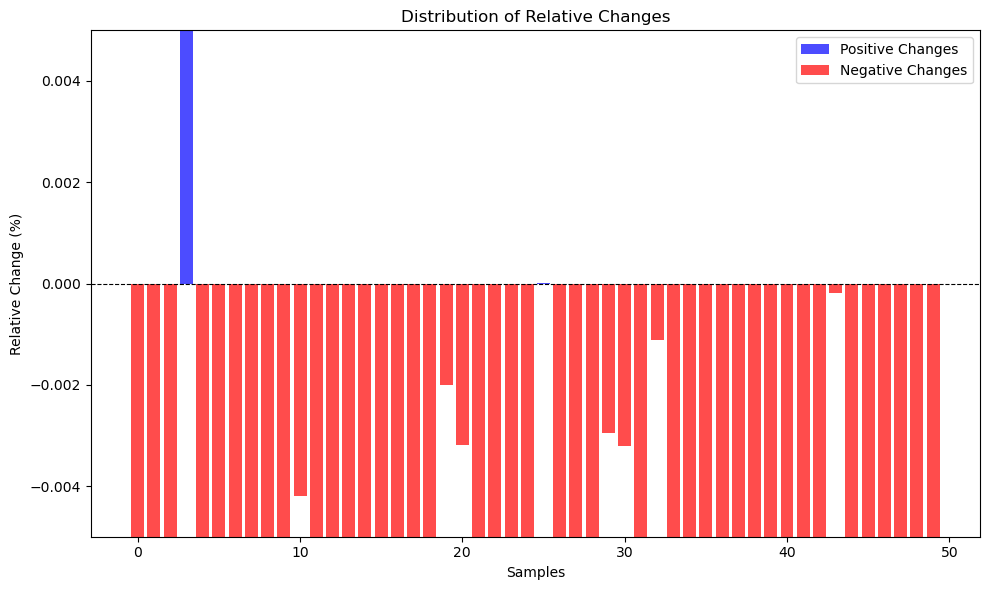

In [26]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

## Final Results

In [28]:
all_exp_results

,Cl Acc,ECS FT,ECS TT,ORC (+),ORC (-)
0,0.88,0.967,0.871,0.131,-11.544
1,0.88,0.967,0.879,3.861,-13.351
2,0.88,0.967,0.873,2.326,-11.690
3,0.78,0.848,0.614,6.077,-27.471
4,0.78,0.848,0.635,10.279,-26.486
5,0.78,0.848,0.618,8.550,-25.020
6,0.88,0.927,0.839,5.497,-12.843
7,0.88,0.927,0.746,3.019,-23.998
8,0.88,0.927,0.749,6.586,-24.601
9,0.94,0.993,0.536,NaN,-45.653


In [29]:
excel_file = path_reports + 'all_exp_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    all_exp_results.to_excel(writer, sheet_name='Random', index=False)